In [1]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.0 MB/s eta 0:00:00


In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
os.environ['SM_FRAMEWORK'] = "tf.keras"
import segmentation_models as sm
from keras.metrics import MeanIoU
import random

2023-11-08 14:25:21.087092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 14:25:22.930912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aayush/anaconda3/envs/fuseenv/lib/python3.7/site-packages/cv2/../../lib64:
2023-11-08 14:25:22.931138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aayush/anaconda3/envs/fuseenv/lib/python3.7

Segmentation Models: using `tf.keras` framework.


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# !unzip /content/drive/MyDrive/landcover/Data/val_images.zip

In [5]:
print(len(os.listdir('/content/train_images/train')))
print(len(os.listdir('/content/train_masks/train')))

16443
16443


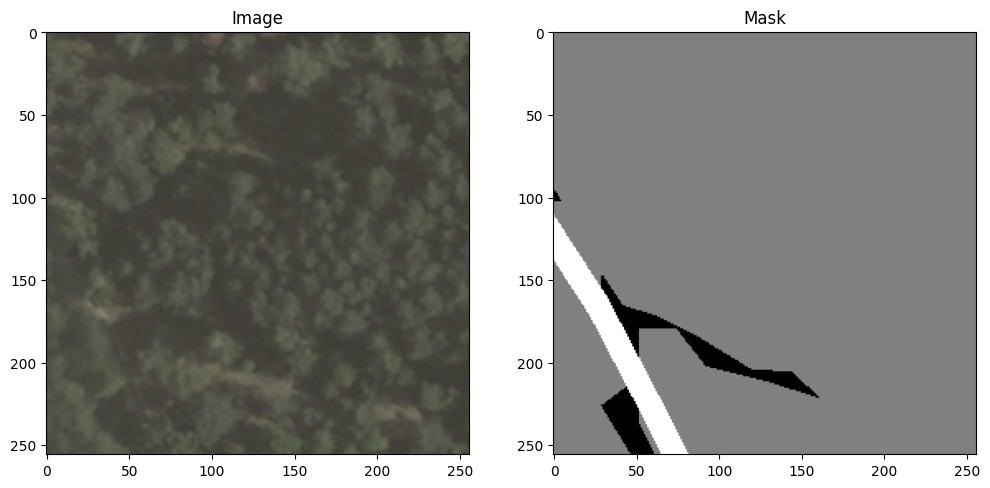

In [6]:
train_img_dir = "/content/train_images/train/"
train_mask_dir = "/content/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


In [7]:
# Define Generator for images and masks so we can read them directly from the drive.

seed=24
batch_size= 16
n_classes=5

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

In [9]:
#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [10]:
def preprocess_data(img, mask, num_class):
    #Scale images
    # img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = (img - img.min()) / (img.max() - img.min())
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)

    return (img,mask)

In [11]:
#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):

    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        # print(img.shape,mask.shape)
        yield (img, mask)


In [12]:
train_img_path = "/content/train_images/"
train_mask_path = "/content/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)

val_img_path = "/content/val_images/"
val_mask_path = "/content/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)

In [3]:
#Make sure the generator is working and that images and masks are indeed lined up.
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()


NameError: name 'train_img_gen' is not defined

In [2]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

NameError: name 'x' is not defined

In [16]:
###########################################################################
#Define the model metrcis and load model.

num_train_imgs = len(os.listdir('/content/train_images/train/'))
num_val_images = len(os.listdir('/content/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=5

In [15]:
print("Model output shape:", model.output_shape)
# print("Target data shape:", target_data.shape)


Model output shape: (None, 256, 256, 5)


In [17]:
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet',
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
print(model.summary())
print(model.input_shape)
#Fit the model
#history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)
#Train the model.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [18]:
from keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='landcover_epoch_{epoch:02d}.hdf5',  # File path to save the model
    save_best_only=False,  # Save the model at every epoch
    save_freq='epoch'  # Save the model after every epoch
)


In [ ]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch,
                  callbacks=[model_checkpoint])

model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')


Epoch 1/25
1027/1027 [==============================] - ETA: 0s - loss: 0.5452 - iou_score: 0.4926

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1027/1027 [==============================] - 324s 279ms/step - loss: 0.5452 - iou_score: 0.4926 - val_loss: 0.8575 - val_iou_score: 0.2398
Epoch 2/25
1027/1027 [==============================] - 255s 249ms/step - loss: 0.4586 - iou_score: 0.5757 - val_loss: 0.4808 - val_iou_score: 0.5563
Epoch 3/25
1027/1027 [==============================] - 253s 247ms/step - loss: 0.4263 - iou_score: 0.6053 - val_loss: 0.4792 - val_iou_score: 0.5565
Epoch 4/25
1027/1027 [==============================] - 213s 207ms/step - loss: 0.4074 - iou_score: 0.6222 - val_loss: 0.4527 - val_iou_score: 0.5873
Epoch 5/25
1027/1027 [==============================] - 221s 215ms/step - loss: 0.3942 - iou_score: 0.6346 - val_loss: 0.5618 - val_iou_score: 0.4989
Epoch 6/25
1027/1027 [==============================] - 211s 206ms/step - loss: 0.3798 - iou_score: 0.6476 - val_loss: 0.4268 - val_iou_score: 0.6063
Epoch 7/25
1027/1027 [==============================] - 240s 233ms/step - loss: 0.3908 - iou_score: 0.6375 - va

In [ ]:
##################################################################
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [14]:
#####################################################

from keras.models import load_model

# model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)
model = load_model("/content/landcover_epoch_06.hdf5", compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 [==============================] - 2s 2s/step
Mean IoU = 0.6488079


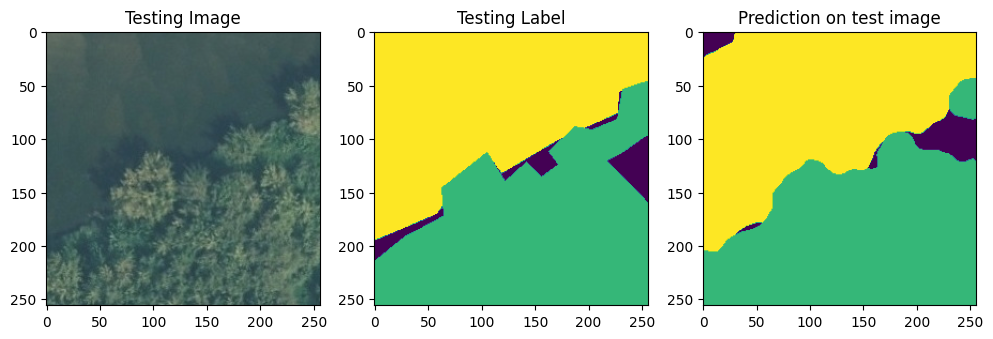

In [21]:
#######################################################
#View a few images, masks and corresponding predictions.
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

In [19]:
!mv /content/landcover_epoch_06.hdf5 /content/drive/MyDrive/

mv: cannot stat '/content/landcover_epoch_06.hdf5': No such file or directory
